/home/duilio/Documentos/Tesis/Prueba_Unet/

### IMPORT

In [1]:
import numpy as np # linear algebra
import tensorflow as tf # for tensorflow based registration
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.util.montage import montage2d
import os
from cv2 import imread, createCLAHE # read and equalize images
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt



/home/duilio/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## PATH  DE LAS IMAGENES

In [3]:
cxr_paths = glob(os.path.join('/home/duilio/Documentos/Tesis/Prueba_Unet/MontgomerySet', '*', '*.jpg'))
cxr_images = [(c_path,
               [os.path.join('/'.join(c_path.split('/')[:-2]),'ManualMask','rightMask', os.path.basename(c_path))]
              ) for c_path in cxr_paths]
print('CXR Images', len(cxr_paths), cxr_paths[0])
print(cxr_images[0])

CXR Images 86 /home/duilio/Documentos/Tesis/Prueba_Unet/MontgomerySet/CXR_png/Imagen121.jpg
('/home/duilio/Documentos/Tesis/Prueba_Unet/MontgomerySet/CXR_png/Imagen121.jpg', ['/home/duilio/Documentos/Tesis/Prueba_Unet/MontgomerySet/ManualMask/rightMask/Imagen121.jpg'])


#### EN LA SIGUIENTE LINEA SE REALIZA UNA PRUEBA PARA VER SI SE CARGAN BIEN LAS IMAGENES

### Con este codigo se pretende discretizar las imagenes
SE PRESENTAN PROBLEMAS CON LA LIBRERIA PIL Y NUMPY, SEGURAMENTE UN PROBLEMA DE VERSIONES SEGUN ESTUVE LEYENDO.

IGUAL PARECE QUE FUNCIONA SIN UTILIZAR ESTA LINEA DE CODIGO

-------------------------------SALTEAR-----------------------------------------

In [5]:
from PIL import Image, ImageFilter

imagen_original=Image.open('/home/duilio/Documentos/Tesis/imagenes_segmentadas/Imagen164.jpg')
tamaño = (3,3)
coeficientes = [1, 2, 1, 2, 4, 2, 1, 2, 1]
foto = imagen_original.filter(ImageFilter.Kernel(tamaño, coeficientes))
#si la imagen no es a escala de grises se hace la conversion
if foto.mode != 'L':
    foto=foto.convert('L')
#otro filtro de mediana
#foto = foto.filter(ImageFilter.Kernel(tamaño, coeficientes))
umbral1=50
umbral2=100
umbral3=250
datos=foto.getdata()
datos_binarios=[]
for x in datos:
    if x<umbral1:
        datos_binarios.append(0)
    else:
        if x<umbral2:
            datos_binarios.append(50)
        else:
            if x<umbral3:
                datos_binarios.append(100)
            else:
                datos_binarios.append(255)
                
nueva_imagen=Image.new('L', foto.size)
nueva_imagen.putdata(datos_binarios)
#ueva_imagen.save('MontgomerySet/Imagen121.jpg')
nueva_imagen.close()
foto.close()


### FUNCIONES PARA LECTURA DE LAS IMAGENES

In [6]:
from skimage.io import imread as imread_raw
from skimage.transform import resize
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore', category=UserWarning, module='skimage') # skimage is really annoying
OUT_DIM = (512, 512)
def imread(in_path, apply_clahe = False, exp_dim=True):
    img_data = imread_raw(in_path)
    n_img = (255*resize(img_data, OUT_DIM, mode = 'constant')).clip(0,255).astype(np.uint8)
    if apply_clahe:
        clahe_tool = createCLAHE(clipLimit=2.0, tileGridSize=(16,16))
        n_img = clahe_tool.apply(n_img)
    if exp_dim:
        return np.expand_dims(n_img, -1)
    else:
        return n_img

In [7]:
img_vol, seg_vol = [], []
for img_path, s_paths in tqdm(cxr_images):
#     print(img_path)
#     print(s_paths)

    img_vol += [imread(img_path)]    
    seg_vol += [cv2.cvtColor(imread(s_paths[0], apply_clahe = False, exp_dim=False), cv2.COLOR_RGB2GRAY)]
#    seg_vol += [imread(s_paths[0], apply_clahe = False, exp_dim=False)]

#     seg_vol += [np.max(np.stack([print(s_path)for s_path in s_paths],0),0)]
#     input()
img_vol = np.stack(img_vol,0)
seg_vol = np.stack(seg_vol,0)
seg_vol = np.expand_dims(seg_vol, -1)
print('Images', img_vol.shape, 'Segmentations', seg_vol.shape)

100%|██████████| 86/86 [00:08<00:00,  9.68it/s]

Images (86, 512, 512, 1) Segmentations (86, 512, 512, 1)


In [8]:
#np.unique(seg_vol[0,:,:,0])

#### SE REALIZAN UNAS PRUEBAS PARA GRAFICAR LAS IMAGENES CARGADAS Y SE OBSERVA EN EL HISTOGRAMA QUE EXISTEN MAS DE 4 CLASES, ESTO SE DEBE SEGURAMENTE A LA PRESENCIA DE RUIDO

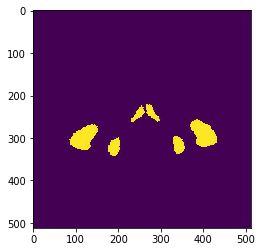

In [9]:
plt.imshow(seg_vol[0,:,:,0])

/home/duilio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  """Entry point for launching an IPython kernel.


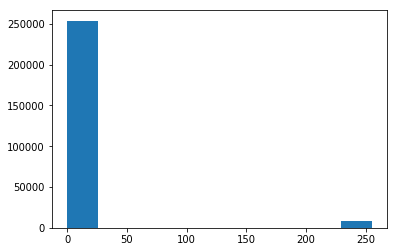

In [10]:
a=plt.hist(seg_vol[0].ravel(255))
# plot(a)

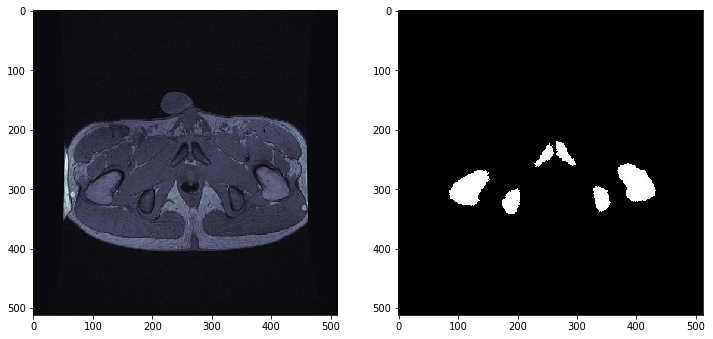

In [11]:
np.random.seed(2018)
t_img, m_img = img_vol[0], seg_vol[0]

fig, (ax_img, ax_mask) = plt.subplots(1,2, figsize = (12, 6))
ax_img.imshow(t_img[:,:,0],
               cmap = 'bone')
ax_mask.imshow(m_img[:,:,0], cmap = 'bone')

# CREACION DE MODELO

SE PROCEDE A REALIZAR UNA  RED U-NET

In [12]:
from keras.layers import Conv2D, Activation, Input, UpSampling2D, concatenate, BatchNormalization
from keras.layers import LeakyReLU
from keras.initializers import RandomNormal
def c2(x_in, nf, strides=1):
    x_out = Conv2D(nf, kernel_size=3, padding='same',
                   kernel_initializer='he_normal', strides=strides)(x_in)
    x_out = LeakyReLU(0.2)(x_out)
    return x_out
def unet_enc(vol_size, enc_nf, pre_filter = 8):
    src = Input(shape=vol_size + (1,), name = 'EncoderInput')
    # down-sample path.
    x_in = BatchNormalization(name = 'NormalizeInput')(src)
    x_in = c2(x_in, pre_filter, 1)
    x0 = c2(x_in, enc_nf[0], 2)  
    x1 = c2(x0, enc_nf[1], 2)  
    x2 = c2(x1, enc_nf[2], 2)  
    x3 = c2(x2, enc_nf[3], 2) 
    return Model(inputs = [src], 
                outputs = [x_in, x0, x1, x2, x3],
                name = 'UnetEncoder')

Using TensorFlow backend.


In [13]:
from keras.models import Model
from keras import layers
def unet(vol_size, enc_nf, dec_nf, full_size=True, edge_crop=48):
    """
    unet network for voxelmorph 
    Args:
        vol_size: volume size. e.g. (256, 256, 256)
        enc_nf: encoder filters. right now it needs to be to 1x4.
            e.g. [16,32,32,32]
            TODO: make this flexible.
        dec_nf: encoder filters. right now it's forced to be 1x7.
            e.g. [32,32,32,32,8,8,3]
            TODO: make this flexible.
        full_size
    """

    # inputs
    raw_src = Input(shape=vol_size + (1,), name = 'ImageInput')
    src = layers.GaussianNoise(0.25)(raw_src)
    enc_model = unet_enc(vol_size, enc_nf)
    # run the same encoder on the source and the target and concatenate the output at each level
    x_in, x0, x1, x2, x3 = [s_enc for s_enc in enc_model(src)]

    x = c2(x3, dec_nf[0])
    x = UpSampling2D()(x)
    x = concatenate([x, x2])
    x = c2(x, dec_nf[1])
    x = UpSampling2D()(x)
    x = concatenate([x, x1])
    x = c2(x, dec_nf[2])
    x = UpSampling2D()(x)
    x = concatenate([x, x0])
    x = c2(x, dec_nf[3])
    x = c2(x, dec_nf[4])
    x = UpSampling2D()(x)
    x = concatenate([x, x_in])
    x = c2(x, dec_nf[5])

    # transform the results into a flow.
    y_seg = Conv2D(1, kernel_size=3, padding='same', name='lungs', activation='softmax')(x)
    y_seg = layers.Cropping2D((edge_crop, edge_crop))(y_seg)
    y_seg = layers.ZeroPadding2D((edge_crop, edge_crop))(y_seg)
    # prepare model
    model = Model(inputs=[raw_src], outputs=[y_seg])
    return model

In [14]:
# use the predefined depths
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,2]
net = unet(OUT_DIM, nf_enc, nf_dec)
# ensure the model roughly works
a= net.predict([np.zeros((1,)+OUT_DIM+(1,))])
print(a.shape)
net.summary()

(1, 512, 512, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ImageInput (InputLayer)         (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 512, 512, 1)  0           ImageInput[0][0]                 
__________________________________________________________________________________________________
UnetEncoder (Model)             [(None, 512, 512, 8) 24388       gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   9248        UnetEncoder[1][4]                
____________________________________________________________________________________________

In [15]:
from keras.optimizers import Adam
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy

reg_param = 1.0
lr = 2e-4
dice_bce_param = 0.0
use_dice = True

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return dice_bce_param*categorical_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

net.compile(optimizer=Adam(lr=lr), 
              loss=[dice_p_bce], 
           metrics = [true_positive_rate, 'accuracy'])

# CREACION DE DATA GENERADOR

ACA CREAMOS UNA HERRAMIENTA PARA LOS DATOS DE ENTRENAMIENTO PROVENIENTES DE LAS RMI

Train (68, 512, 512, 1) Test (18, 512, 512, 1) -0.7394007918924381 1.0078740157480315
Seg (68, 512, 512, 1) 255.0 [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.
  28.  29.  30.  31.  32.  33.  34. 222. 223. 224. 225. 226. 227. 228.
 229. 230. 231. 232. 233. 234. 235. 236. 237. 238. 239. 240. 241. 242.
 243. 244. 245. 246. 247. 248. 249. 250. 251. 252. 253. 254. 255.]


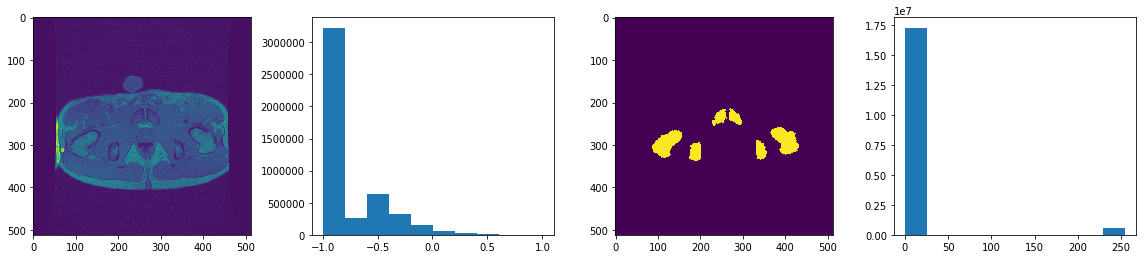

In [16]:
from sklearn.model_selection import train_test_split
train_vol, test_vol, train_seg, test_seg = train_test_split((img_vol-127.0)/127.0, 
                                                            (seg_vol).astype(np.float32), 
                                                            test_size = 0.2, 
                                                            random_state = 2018)
print('Train', train_vol.shape, 'Test', test_vol.shape, test_vol.mean(), test_vol.max())
print('Seg', train_seg.shape, train_seg.max(), np.unique(train_seg.ravel()))
fig, (ax1, ax1hist, ax2, ax2hist) = plt.subplots(1, 4, figsize = (20, 4))
ax1.imshow(test_vol[0, :, :, 0])
ax1hist.hist(test_vol.ravel())
ax2.imshow(test_seg[0, :, :, 0])
ax2hist.hist(train_seg.ravel());

# AUMENTANDO DATA



In [17]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 5, 
                  width_shift_range = 0.05, 
                  height_shift_range = 0.05, 
                  shear_range = 0.01,
                  zoom_range = [0.8, 1.2],  
               # anatomically it doesnt make sense, but many images are flipped
                  horizontal_flip = True,  
                  vertical_flip = False,
                  fill_mode = 'nearest',
               data_format = 'channels_last')

image_gen = ImageDataGenerator(**dg_args)

def gen_augmented_pairs(in_vol, in_seg, batch_size = 16):
    while True:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_vol = image_gen.flow(in_vol, batch_size = batch_size, seed = seed)
        g_seg = image_gen.flow(in_seg, batch_size = batch_size, seed = seed)
        for i_vol, i_seg in zip(g_vol, g_seg):
            yield i_vol, i_seg

In [18]:
train_gen = gen_augmented_pairs(train_vol, train_seg, batch_size = 16)
test_gen = gen_augmented_pairs(test_vol, test_seg, batch_size = 16)
train_X, train_Y = next(train_gen)
test_X, test_Y = next(test_gen)
print(train_X.shape, train_Y.shape)
print(test_X.shape, test_Y.shape)


(16, 512, 512, 1) (16, 512, 512, 1)
(16, 512, 512, 1) (16, 512, 512, 1)


# TRAINING DATA

Text(0.5,1,'Seg Image')

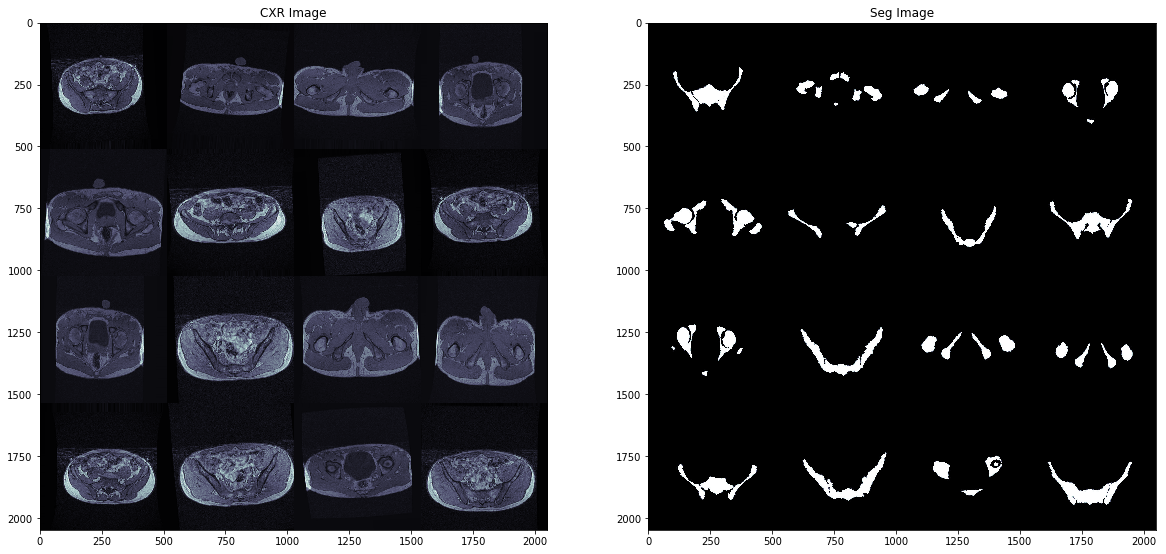

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(train_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(train_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')

# VALIDATION DATA

Text(0.5,1,'Seg Image')

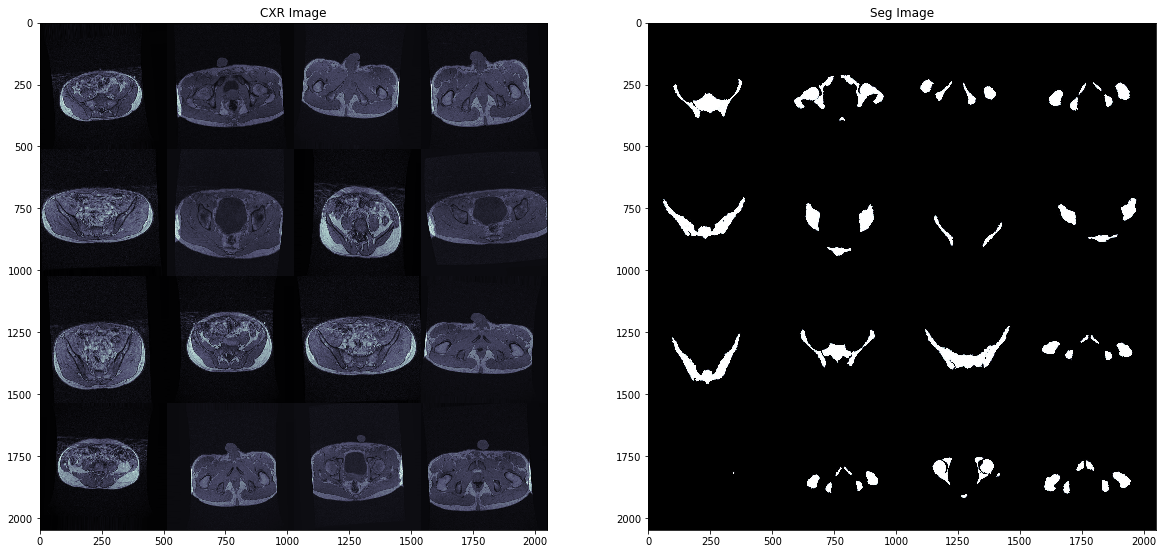

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage2d(test_X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('CXR Image')
ax2.imshow(montage2d(test_Y[:, :, :, 0]), cmap = 'bone')
ax2.set_title('Seg Image')

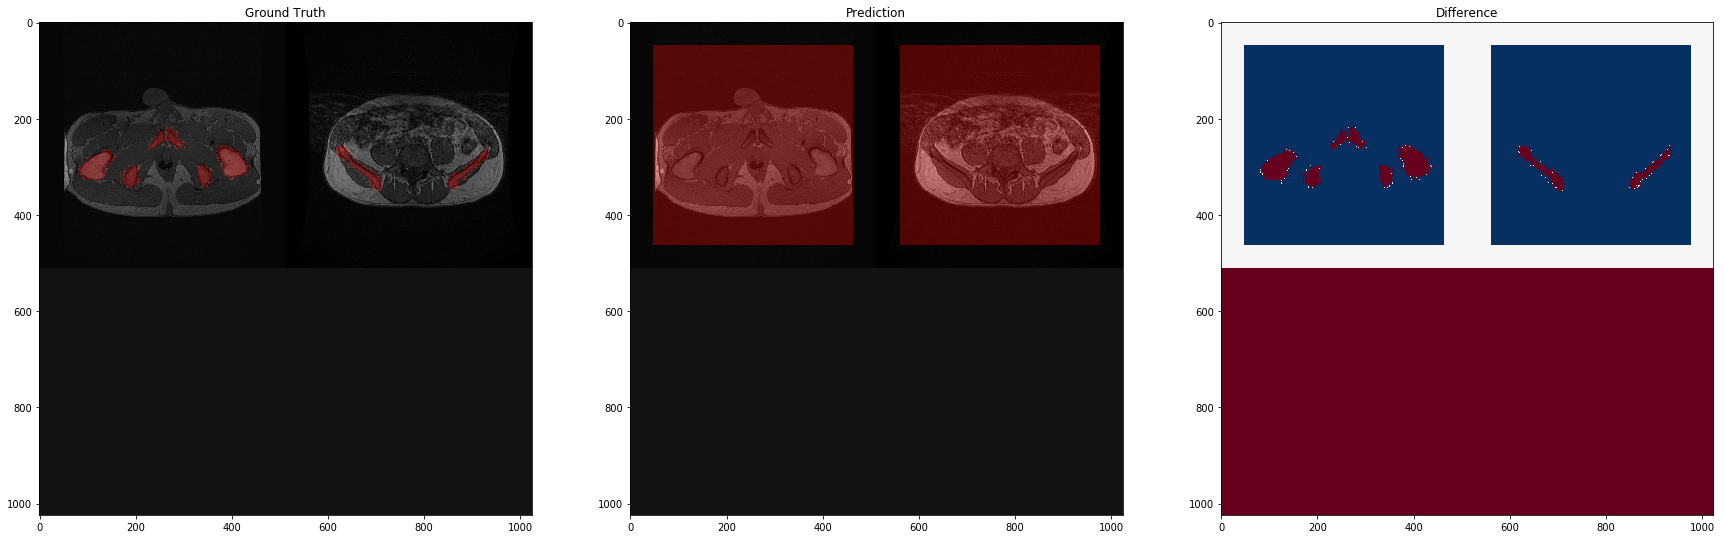

In [21]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
try:
    from skimage.util.montage import montage2d
except:
    from skimage.util import montage2d
def add_boundary(in_img, in_seg, cmap = 'bone', norm = True, add_labels = True):
    if norm:
        n_img = (1.0*in_img-in_img.min())/(1.1*(in_img.max()-in_img.min()))
    else:
        n_img = in_img
    rgb_img = plt.cm.get_cmap(cmap)(n_img)[:, :, :3]
#     rgb_img = n_img

    if add_labels:
        return label2rgb(image = rgb_img, label = in_seg.astype(int), bg_label = 0)
    else:
        return mark_boundaries(image = rgb_img, label_img = in_seg.astype(int), color = (0, 1, 0), mode = 'thick')
def show_full_st(in_img, in_seg, gt_seg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]), 
                           montage2d(gt_seg[:, :, :, 0]>0.5))
#                             montage2d(gt_seg[:, :, :, 0]))                           
    ax1.imshow(out_mtg)
    ax1.set_title('Ground Truth')
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]), 
                           montage2d(in_seg[:, :, :, 0]>0.5))
    ax2.imshow(out_mtg)
    ax2.set_title('Prediction')
    out_mtg = montage2d(in_seg[:, :, :, 0]-gt_seg[:, :, :, 0])
    ax3.imshow(out_mtg, cmap='RdBu', vmin=-1, vmax=1)
    ax3.set_title('Difference')
def show_examples(n=1, with_roi = True):
#     roi_func = lambda x: x[:, 
#                                OUT_DIM[0]//2-32:OUT_DIM[0]//2+32,
#                                OUT_DIM[1]//2-64:OUT_DIM[1]//2,
#                                :
#                               ]
#     for (test_X, test_Y), _ in zip(test_gen, range(n)):
#         seg_Y = net.predict(test_X)
#         show_full_st(test_X, seg_Y, test_Y)
# #         show_full_st(roi_func(test_X), roi_func(seg_Y), roi_func(test_Y))

#     seg_Y = net.predict(test_X)
#     show_full_st(test_X, seg_Y, test_Y)
    seg_Y = net.predict(img_vol[0:2])
    show_full_st(img_vol[0:2], seg_Y, seg_vol[0:2])
#         show_full_st(roi_func(test_X), roi_func(seg_Y), roi_func(test_Y))

show_examples(1)

# img_vol[0], seg_vol[0]



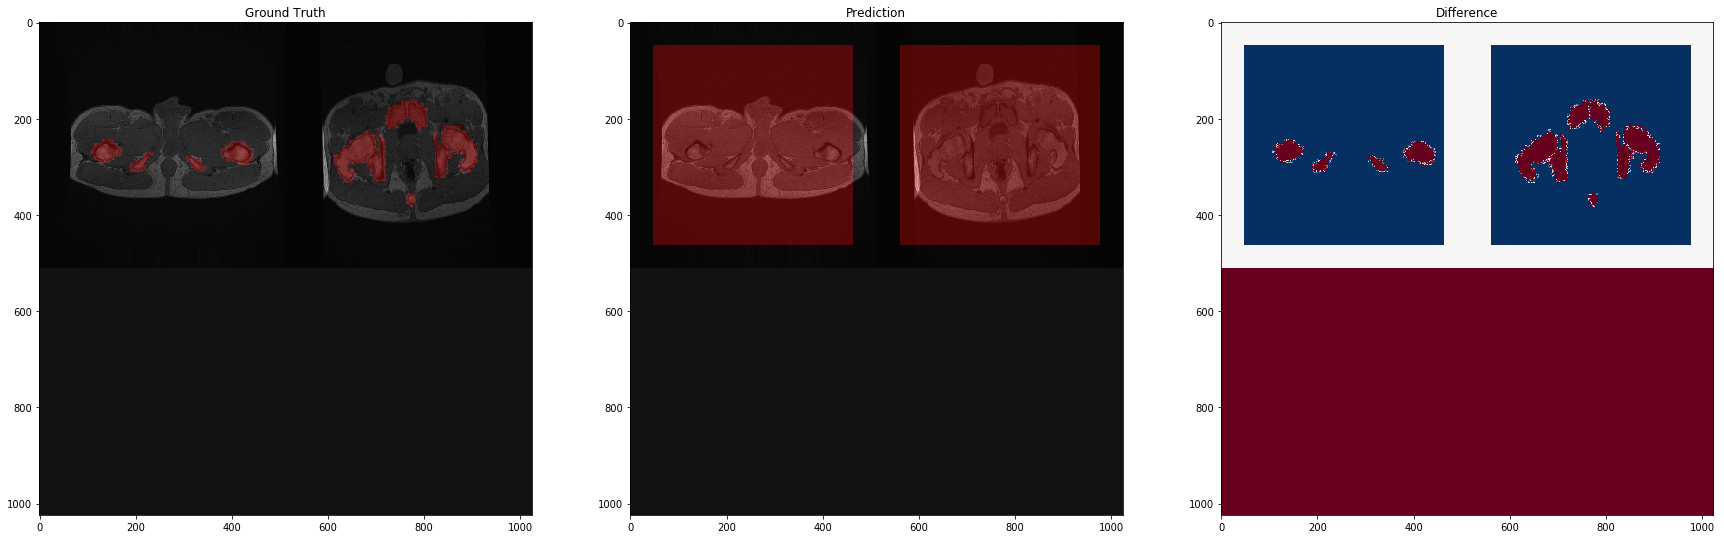

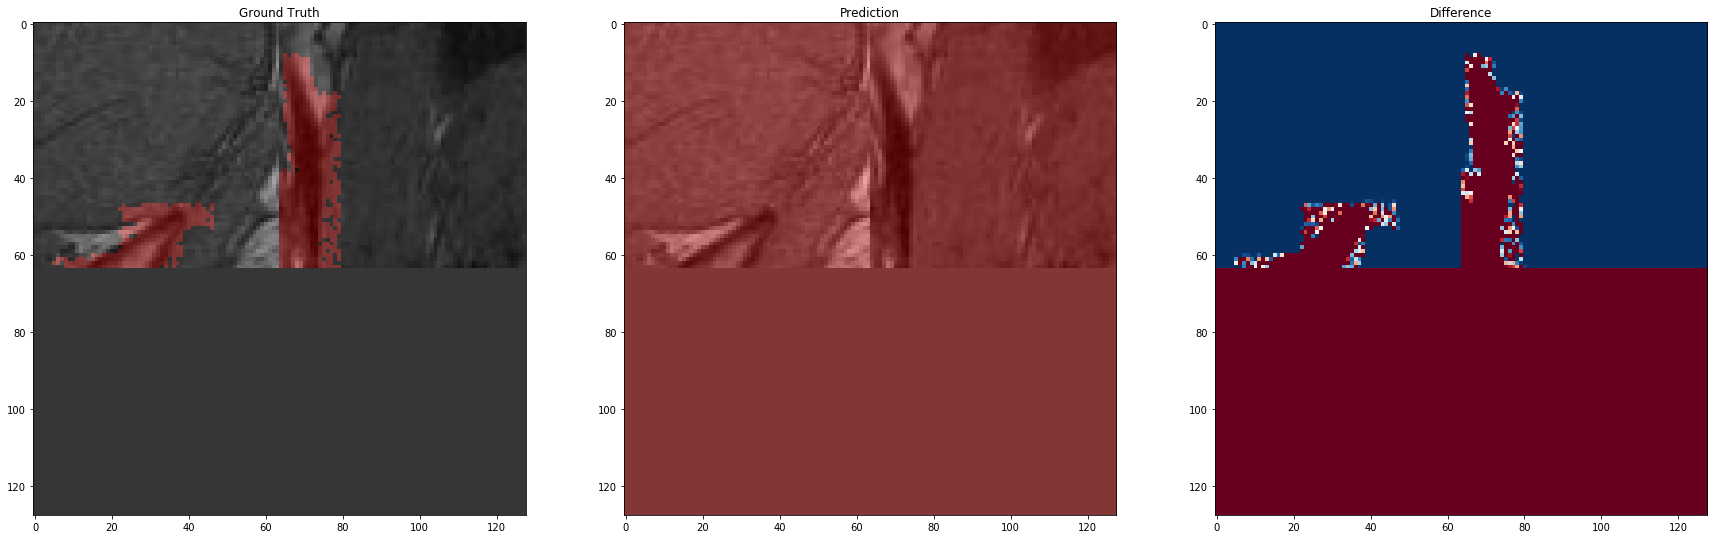

In [22]:
from skimage.segmentation import mark_boundaries
from skimage.color import label2rgb
try:
    from skimage.util.montage import montage2d
except:
    from skimage.util import montage2d
def add_boundary(in_img, in_seg, cmap = 'bone', norm = True, add_labels = True):
    if norm:
        n_img = (1.0*in_img-in_img.min())/(1.1*(in_img.max()-in_img.min()))
    else:
        n_img = in_img
    rgb_img = plt.cm.get_cmap(cmap)(n_img)[:, :, :3]
    if add_labels:
        return label2rgb(image = rgb_img, label = in_seg.astype(int), bg_label = 0)
    else:
        return mark_boundaries(image = rgb_img, label_img = in_seg.astype(int), color = (0, 1, 0), mode = 'thick')
def show_full_st(in_img, in_seg, gt_seg):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]),
                           montage2d(gt_seg[:, :, :, 0]>0.5))
    ax1.imshow(out_mtg)
    ax1.set_title('Ground Truth')
    out_mtg = add_boundary(montage2d(in_img[:, :, :, 0]),
                           montage2d(in_seg[:, :, :, 0]>0.5))
    ax2.imshow(out_mtg)
    ax2.set_title('Prediction')
    out_mtg = montage2d(in_seg[:, :, :, 0]-gt_seg[:, :, :, 0])
    ax3.imshow(out_mtg, cmap='RdBu', vmin=-1, vmax=1)
    ax3.set_title('Difference')
def show_examples(n=1, with_roi = True):
    roi_func = lambda x: x[:,
                               OUT_DIM[0]//2-32:OUT_DIM[0]//2+32,
                               OUT_DIM[1]//2-64:OUT_DIM[1]//2,
                               :
                              ]
    for (test_X, test_Y), _ in zip(test_gen, range(n)):
        seg_Y = net.predict(test_X)
        show_full_st(test_X, seg_Y, test_Y)
        show_full_st(roi_func(test_X), roi_func(seg_Y), roi_func(test_Y))

show_examples(1)


In [24]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [ ]:
from IPython.display import clear_output
loss_history = net.fit_generator(train_gen, 
                  steps_per_epoch=len(train_vol)//train_X.shape[0],
                  epochs = 2,
                  validation_data = (test_vol, test_seg),
                  callbacks=callbacks_list
                 )
clear_output()

Epoch 1/2


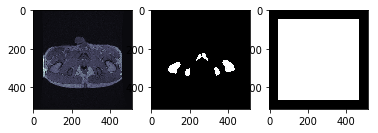

In [23]:
seg_Y = net.predict(img_vol[0:2])
fig, (ax_img, ax_mask, ax_predict) = plt.subplots(1,3, figsize = (6, 6))
ax_img.imshow(img_vol[0,:,:,0],
               cmap = 'bone')
ax_mask.imshow(seg_vol[0,:,:,0], cmap = 'bone')
ax_predict.imshow(seg_Y[0,:,:,0], cmap = 'bone')